## CNN U Net - Automated Detection and Segmentation of Lung Lesions in Chest CT Scans for COVID-19 Diagnosis

# Part 1 - Business Problem

**Background**

Hospitals and healthcare providers face significant challenges in the timely and accurate diagnosis of COVID-19 and other respiratory diseases, especially when resources are limited and demand is high. Chest CT scans are a vital imaging modality for detecting lung infections, but interpreting these images manually is time-consuming and requires experienced radiologists. This creates a bottleneck in patient triage and can lead to delays in treatment.

**Objective**

To develop an AI-powered solution that automatically detects and segments lung lesions (such as those caused by COVID-19) in chest CT scans. The goal is to accelerate the diagnostic process, reduce radiologist workload, and improve patient outcomes by providing fast, consistent, and accurate identification of infected lung regions.

**Expected Benefits**

1. **Faster Diagnosis:** Automated segmentation enables rapid triage and early intervention for patients with severe lung involvement.

2. **Consistency:** AI models can provide standardized and repeatable assessments, reducing inter-observer variability among radiologists.

3. **Resource Optimization:** By prioritizing cases with severe findings, hospitals can better allocate critical care resources.

4. **Scalability:** The solution can be deployed across multiple hospitals, assisting in areas with a shortage of experienced radiologists.

**Key Questions**

- Can a deep learning model (such as U-Net with VGG16 encoder) segment infected lung areas in CT images as accurately as experienced radiologists?

- What is the expected improvement in diagnostic time and accuracy with the deployment of this AI solution?

- How will the solution be integrated into the clinical workflow to maximize its impact?

In [3]:
# importing libraries

#
import os

# numerical and data manipulation libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.model_selection import train_test_split

# evaluation metrics and class balancing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#
import cv2

# deep learning frameworks
import keras
import tensorflow as tf

# image preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# model architecture and training utilities
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Part 2 - Database

In [4]:
# Default image size (you can try 128 if memory is an issue)
IMG_SIZE = 256
BATCH_SIZE = 8

In [10]:
# Directories for images and masks
IMG_DIR = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames'
MASK_DIR = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks'


In [11]:
# List of all image files
all_files = sorted(os.listdir(IMG_DIR))

# Part 3 - Training and testing

In [12]:
# Split files into train, validation, and test sets
train_files, test_files = train_test_split(all_files, test_size=0.15, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.15, random_state=42)

print(f"Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

Train: 1971, Validation: 348, Test: 410


In [13]:
# Data generator for CT image segmentation (inherits from Keras Sequence)
class CTDataGen(Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size

    # Returns the number of batches per epoch
    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    # Loads and returns a batch of images and masks
    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs, masks = [], []
        for fname in batch_files:
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0
            imgs.append(np.expand_dims(img, axis=-1))
            mask = cv2.imread(os.path.join(self.mask_dir, fname), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = (mask > 127).astype(np.float32)  # Binarize mask
            masks.append(np.expand_dims(mask, axis=-1))
        return np.array(imgs), np.array(masks)

# Part 4 - Architecture Network Neural Convolutional U-Net

In [14]:
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_shape)
    # Encoder: Downsampling path
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # Bridge: Bottleneck of the U-Net
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    # Decoder: Upsampling path
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(c9)

    # Output layer: 1 channel with sigmoid activation (for binary segmentation)
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [15]:
# Generator for the training set
train_gen = CTDataGen(train_files, IMG_DIR, MASK_DIR, BATCH_SIZE, IMG_SIZE)

# Generator for the validation set
val_gen = CTDataGen(val_files, IMG_DIR, MASK_DIR, BATCH_SIZE, IMG_SIZE)

# Generator for the test set
test_gen = CTDataGen(test_files, IMG_DIR, MASK_DIR, BATCH_SIZE, IMG_SIZE)

# Part 5 - Model 1 U-Net

In [16]:
# Build the U-Net model
model = build_unet()

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Display the model architecture summary
model.summary()

2025-05-29 00:59:32.843369: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 256)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
%%time

# Train the model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 635s 3s/step - accuracy: 0.9821 - loss: 0.1744 - val_accuracy: 0.9850 - val_loss: 0.0633
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9847 - loss: 0.0594 - val_accuracy: 0.9854 - val_loss: 0.0469
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9862 - loss: 0.0457 - val_accuracy: 0.9866 - val_loss: 0.0427
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.9890 - loss: 0.0335 - val_accuracy: 0.9909 - val_loss: 0.0262
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.9915 - loss: 0.0239 - val_accuracy: 0.9926 - val_loss: 0.0202
CPU times: user 2h 45min 39s, sys: 20min 40s, total: 3h 6min 20s
Wall time: 52min 31s


# Part 6 - Metrics and evaluation

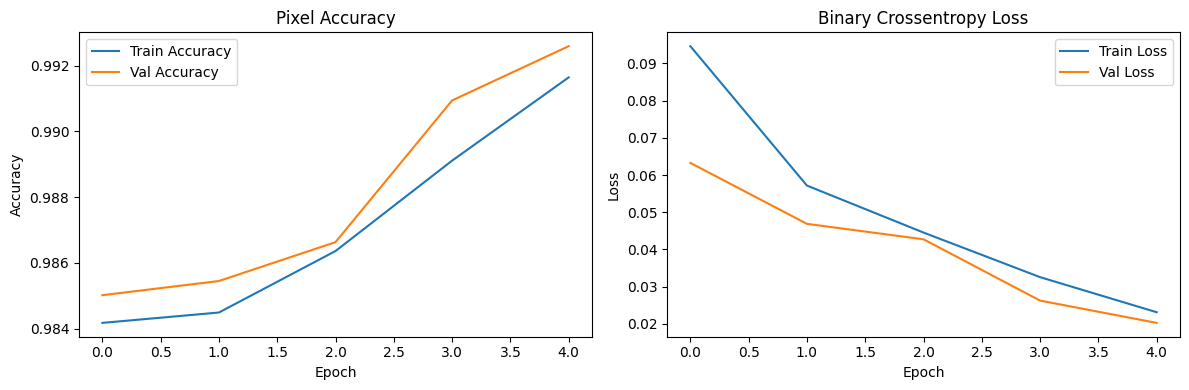

In [18]:
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Pixel Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Binary Crossentropy Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


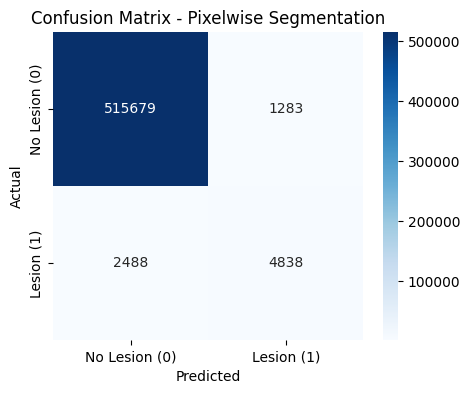

In [19]:
# Get a batch from the test_gen
imgs, masks_true = test_gen[0]
masks_pred = model.predict(imgs)

# Flatten the masks (pixel by pixel)
all_true = []
all_pred = []
for i in range(masks_true.shape[0]):
    true_mask = masks_true[i][:,:,0].astype(np.uint8).flatten()
    pred_mask = (masks_pred[i][:,:,0] > 0.5).astype(np.uint8).flatten()
    all_true.extend(true_mask)
    all_pred.extend(pred_mask)

# Confusion matrix
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['No Lesion (0)', 'Lesion (1)'],
            yticklabels=['No Lesion (0)', 'Lesion (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Pixelwise Segmentation")
plt.show()

In [20]:
# Classification report
target_names = ['No Lesion (0)', 'Lesion (1)']
print(classification_report(all_true, all_pred, target_names=target_names, digits=4))

               precision    recall  f1-score   support

No Lesion (0)     0.9952    0.9975    0.9964    516962
   Lesion (1)     0.7904    0.6604    0.7196      7326

     accuracy                         0.9928    524288
    macro avg     0.8928    0.8290    0.8580    524288
 weighted avg     0.9923    0.9928    0.9925    524288



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


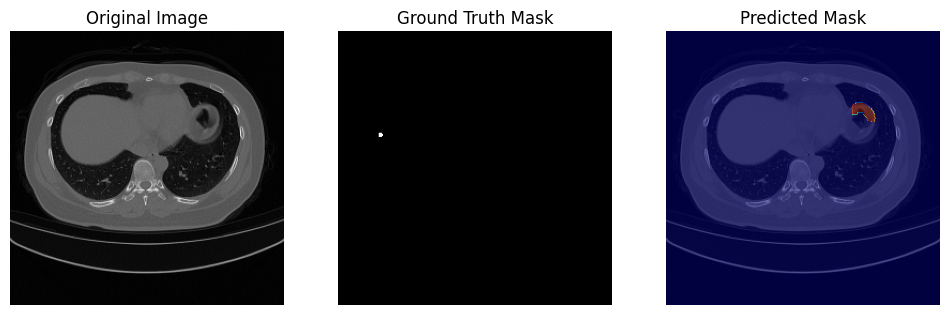

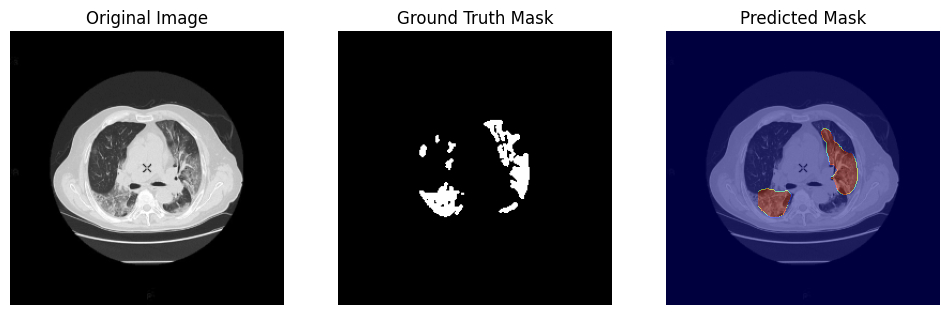

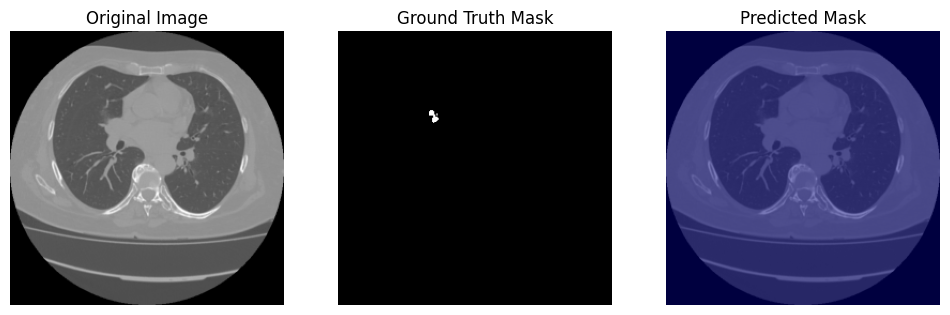

In [21]:
# Get a batch from the test set
imgs, true_masks = test_gen[0]
pred_masks = model.predict(imgs)

for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i][:,:,0], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(true_masks[i][:,:,0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(imgs[i][:,:,0], cmap='gray')
    plt.imshow(pred_masks[i][:,:,0] > 0.5, cmap='jet', alpha=0.5)
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

In [22]:
# Saving Neural Network Model - U-Net 1
model.save('unet_1_segmentacao.h5')

# Part 7 - Image prediction with U-Net model 1

In [23]:
import cv2
from tensorflow.keras.models import load_model

# If you did not use custom metrics:
model_pred = load_model('/kaggle/working/unet_1_segmentacao.h5')

In [24]:
frames_dir = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames'
img_filename = 'Jun_coronacases_case10_118.png'  # or any filename from the list
img_path = os.path.join(frames_dir, img_filename)


In [25]:
# Load the image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Resize to (256, 256)
img = cv2.resize(img, (256, 256))

# Normalize pixel values to [0, 1]
img = img / 255.0

# Add batch and channel dimensions: (1, 256, 256, 1)
img_input = np.expand_dims(img, axis=(0, -1))

In [26]:
# Make prediction
mask_pred = model_pred.predict(img_input)[0, :, :, 0]
mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


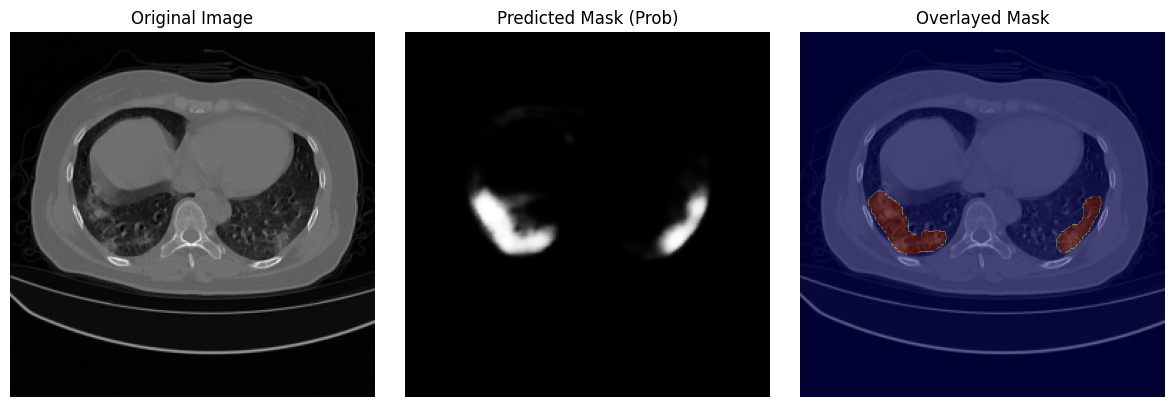

In [27]:
# Visualization
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_pred, cmap='gray')
plt.title('Predicted Mask (Prob)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('Overlayed Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
# Load the corresponding ground truth mask
mask_path = os.path.join('/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks', img_filename)

In [30]:
mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_true = cv2.resize(mask_true, (256, 256))
mask_true_bin = (mask_true > 127).astype(np.uint8)

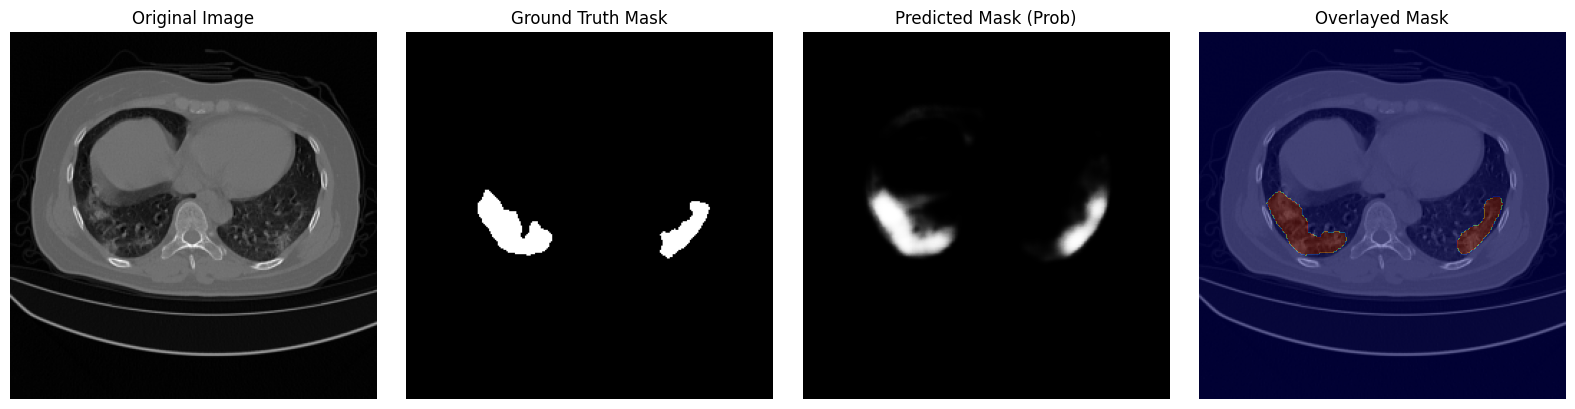

52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.9919 - loss: 0.0226
Accuracy reported by Keras: 0.9921
Pixel-wise accuracy (image): 0.9940


In [31]:
# Plot side by side
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask_true_bin, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(mask_pred, cmap='gray')
plt.title('Predicted Mask (Prob)')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('Overlayed Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

results = model.evaluate(test_gen, verbose=1)
# results[1] is the accuracy if you compiled with metrics=['accuracy']
print(f"Accuracy reported by Keras: {results[1]:.4f}")

accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
print(f"Pixel-wise accuracy (image): {accuracy_pixel:.4f}")

# Part 8 - Model 2 U-Net

In [32]:
# Improved Model 2 - Custom Metrics

def dice_coef(y_true, y_pred, smooth=1):
    """Dice coefficient metric for segmentation."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """Intersection over Union (IoU) metric for segmentation."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [33]:
# Build the U-Net model (optionally specify input shape)
model2 = build_unet()  # or build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1))

# Compile the model with custom metrics
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef, iou_coef])

# Display the model architecture summary
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 128)    │        131,200 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
history = model2.fit(train_gen,
                     validation_data=val_gen,
                     epochs=5  # you can increase this number if desired!
                    )

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - accuracy: 0.9641 - dice_coef: 0.0253 - iou_coef: 0.0129 - loss: 0.1858 - val_accuracy: 0.9850 - val_dice_coef: 0.0746 - val_iou_coef: 0.0389 - val_loss: 0.0565
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - accuracy: 0.9844 - dice_coef: 0.0874 - iou_coef: 0.0459 - loss: 0.0578 - val_accuracy: 0.9850 - val_dice_coef: 0.1490 - val_iou_coef: 0.0811 - val_loss: 0.0509
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.9850 - dice_coef: 0.1870 - iou_coef: 0.1044 - loss: 0.0449 - val_accuracy: 0.9871 - val_dice_coef: 0.2897 - val_iou_coef: 0.1728 - val_loss: 0.0389
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 631s 3s/step - accuracy: 0.9872 - dice_coef: 0.3375 - iou_coef: 0.2092 - loss: 0.0376 - val_accuracy: 0.9898 - val_dice_coef: 0.3916 - val_iou_coef: 0.2477 - val_loss: 0.0307
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 640s 3s/step - accuracy: 0.9904 - dice_coef: 0.4772 - iou_coef: 0.3187 - loss: 0.0277 - val_accuracy: 0.9

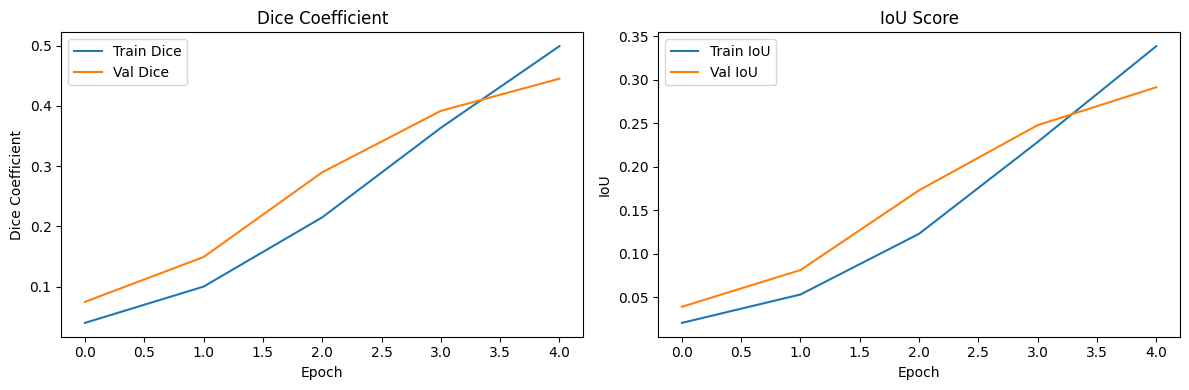

In [35]:
plt.figure(figsize=(12,4))

# Dice Coefficient plot
plt.subplot(1,2,1)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient')

# IoU plot
plt.subplot(1,2,2)
plt.plot(history.history['iou_coef'], label='Train IoU')
plt.plot(history.history['val_iou_coef'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU Score')

plt.tight_layout()
plt.show()

In [36]:
# Pegue um batch de teste (imagens e máscaras reais)
imgs, masks_true = test_gen[0]  # Pega o primeiro batch

In [37]:
# Faça a predição no batch
masks_pred = model2.predict(imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


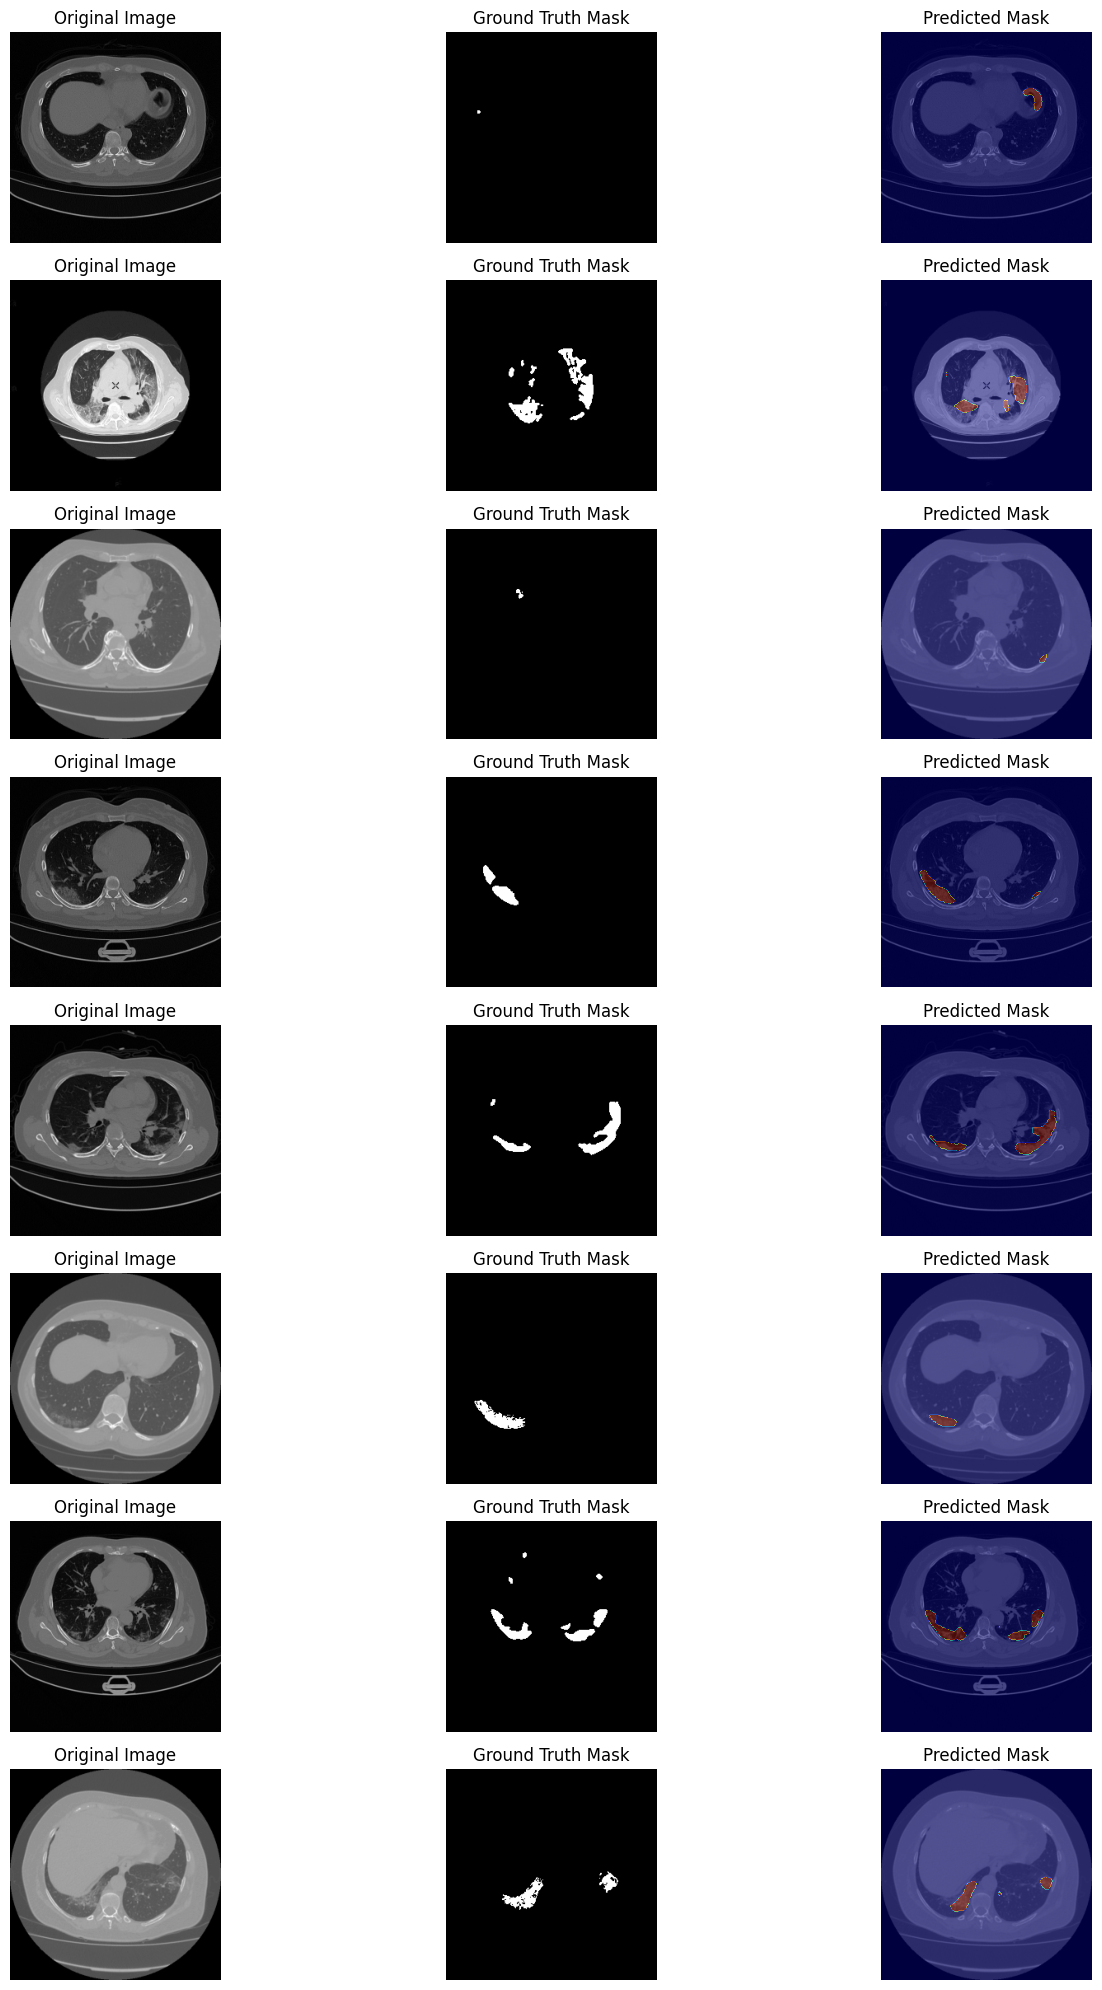

In [38]:
# Get a test batch (images and ground truth masks)
imgs, masks_true = test_gen[0]  # Get the first batch

# Make predictions on the batch
masks_pred = model2.predict(imgs)

n_examples = 8  # Number of examples to display (change as needed)
plt.figure(figsize=(15, 2.5 * n_examples))  # Height proportional to number of examples

for i in range(n_examples):
    # Original image
    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(imgs[i][:,:,0], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(masks_true[i][:,:,0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    # Predicted mask (overlaid on the image)
    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(imgs[i][:,:,0], cmap='gray')
    plt.imshow((masks_pred[i][:,:,0] > 0.5), cmap='jet', alpha=0.5)
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Part 9 - Explanation of Dice Coefficient and IoU Metrics (Image Prediction U-Net)

**Explanation of Dice Coefficient and IoU Metrics**

**Dice Coefficient** and **Intersection over Union (IoU)** are two widely used metrics for evaluating the performance of image segmentation models, especially in medical imaging.

### **Dice Coefficient**

* The Dice coefficient (also known as the Sørensen–Dice index) measures the overlap between the predicted segmentation mask and the ground truth mask.
* It ranges from 0 (no overlap) to 1 (perfect overlap).
* **Formula:**

  $$
  Dice = \frac{2 \cdot |Prediction \cap GroundTruth|}{|Prediction| + |GroundTruth|}
  $$
  
* In simple terms, Dice calculates the similarity between two samples and is particularly useful for evaluating tasks with imbalanced classes, such as lesion or organ segmentation.

### **Intersection over Union (IoU)**

* IoU, also called the Jaccard Index, measures the ratio between the intersection and the union of the predicted and ground truth masks.
* It also ranges from 0 (no overlap) to 1 (perfect overlap).
* **Formula:**

  $$
  IoU = \frac{|Prediction \cap GroundTruth|}{|Prediction \cup GroundTruth|}
  $$
* IoU is a stricter metric than Dice and penalizes false positives and false negatives more heavily.

### **Interpretation**

* **Higher values** (closer to 1) indicate better segmentation performance.
* Dice and IoU are preferred over simple pixel accuracy, especially when the region of interest (e.g., a lesion) occupies only a small part of the image.
* In practice, Dice values above 0.8 and IoU values above 0.7 are considered strong for medical segmentation tasks.

**In summary:**

Both metrics quantify the overlap between predicted and true segmentation masks, but Dice is more forgiving, while IoU is more strict. Reporting both gives a more complete evaluation of your model's segmentation quality.

In [39]:
# Function to calculate the Dice coefficient (measures overlap between prediction and ground truth)
def dice_coef_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Function to calculate Intersection over Union (IoU) metric (stricter overlap measure)
def iou_coef_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Loop over test examples to compute and print Dice and IoU for each image
for i in range(n_examples):
    # Calculate Dice and IoU for the current example
    dice = dice_coef_np(masks_true[i][:,:,0], (masks_pred[i][:,:,0] > 0.5))
    iou = iou_coef_np(masks_true[i][:,:,0], (masks_pred[i][:,:,0] > 0.5))
    print(f"Example {i+1} | Dice: {dice:.3f} | IoU: {iou:.3f}")

Example 1 | Dice: 0.003 | IoU: 0.003
Example 2 | Dice: 0.448 | IoU: 0.289
Example 3 | Dice: 0.009 | IoU: 0.009
Example 4 | Dice: 0.766 | IoU: 0.620
Example 5 | Dice: 0.779 | IoU: 0.638
Example 6 | Dice: 0.505 | IoU: 0.339
Example 7 | Dice: 0.749 | IoU: 0.599
Example 8 | Dice: 0.613 | IoU: 0.442


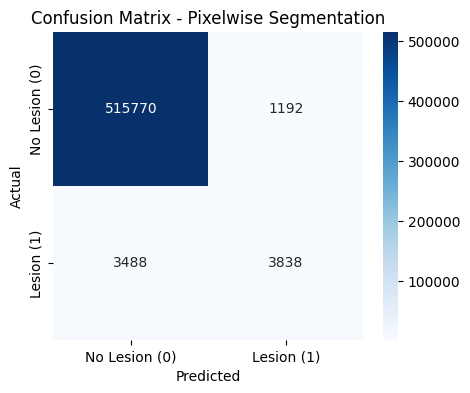

In [40]:
all_true = []
all_pred = []

n_examples = masks_true.shape[0]  # Now no IndexError; get number of examples in batch

# Loop over all examples to flatten masks and collect predictions and ground truth pixels
for i in range(n_examples):
    true_mask = masks_true[i][:,:,0].astype(np.uint8).flatten()  # Flatten ground truth mask
    pred_mask = (masks_pred[i][:,:,0] > 0.5).astype(np.uint8).flatten()  # Flatten predicted mask (threshold at 0.5)
    all_true.extend(true_mask)  # Append true pixels to list
    all_pred.extend(pred_mask)  # Append predicted pixels to list

# Compute confusion matrix for pixel-wise segmentation
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['No Lesion (0)', 'Lesion (1)'],  # Labels in English
            yticklabels=['No Lesion (0)', 'Lesion (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Pixelwise Segmentation")
plt.show()

In [41]:
from sklearn.metrics import classification_report

# n_examples = masks_true.shape[0]  # Already defined above
# all_true and all_pred have already been accumulated as shown in the previous code

target_names = ['No Lesion (0)', 'Lesion (1)']  # Class labels in English
print(classification_report(all_true, all_pred, target_names=target_names, digits=4))


               precision    recall  f1-score   support

No Lesion (0)     0.9933    0.9977    0.9955    516962
   Lesion (1)     0.7630    0.5239    0.6212      7326

     accuracy                         0.9911    524288
    macro avg     0.8782    0.7608    0.8084    524288
 weighted avg     0.9901    0.9911    0.9903    524288



# Part 10 - Prediction 2 image as U-Net 2 model

In [42]:
# Saving Neural Network Model - U-Net 2
# Save in the standard Keras format (as an .h5 file or SavedModel directory)
model2.save('unet_2_segmentacao.h5')

In [43]:
# 1. Path to the newly saved model
model_path2 = '/kaggle/working/unet_2_segmentacao.h5'

In [44]:
# 2. Load the saved model
model2 = load_model(model_path2)

In [45]:
# 3. Choose an image from the dataset
# /kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames/Jun_coronacases_case10_141.png

img_filename = 'Jun_coronacases_case10_141.png'  # any filename from the list!
img_path = os.path.join(frames_dir, img_filename)
mask_path = os.path.join('/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks', img_filename)

In [46]:
# 4. Load and preprocess the image (256x256, 1 channel)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = img / 255.0
img_input = np.expand_dims(img, axis=(0, -1))  # shape (1, 256, 256, 1)

In [47]:
# 5. Make the prediction
mask_pred = model.predict(img_input)[0, :, :, 0]
mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


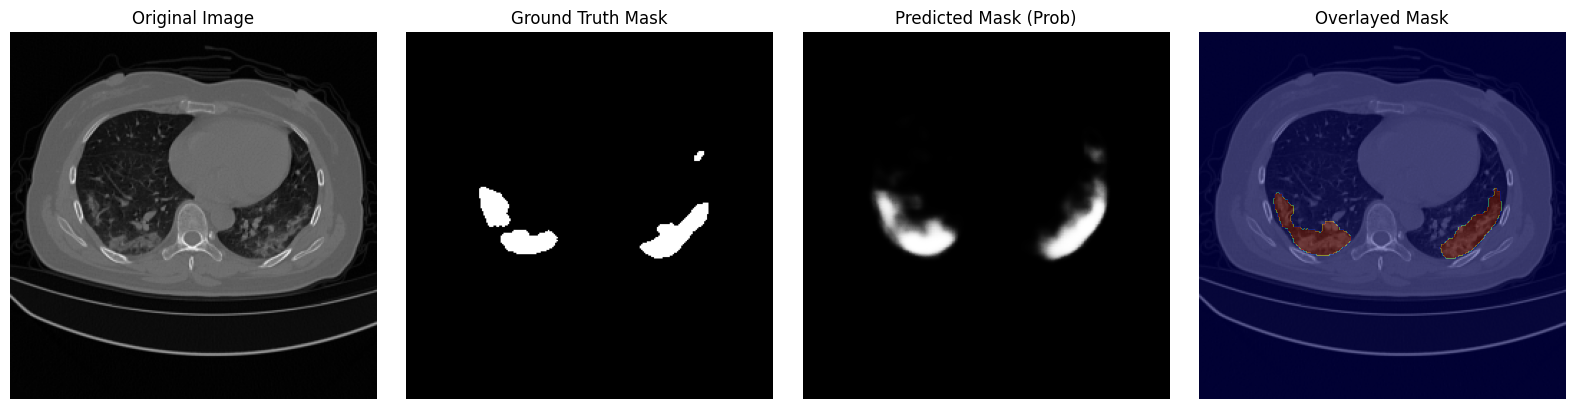

Pixel-wise accuracy (image): 0.9899


In [48]:
# 6. (Optional) Load the ground truth mask
mask_path = os.path.join('/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks', img_filename)
mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_true = cv2.resize(mask_true, (256, 256))
mask_true_bin = (mask_true > 127).astype(np.uint8)

# 7. Visualize everything
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask_true_bin, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(mask_pred, cmap='gray')
plt.title('Predicted Mask (Prob)')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img, cmap='gray')
plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
plt.title('Overlayed Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

# 8. Calculate the pixel-wise accuracy for this image:
accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
print(f"Pixel-wise accuracy (image): {accuracy_pixel:.4f}")

In [49]:
# Paths
img_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
mask_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks'

model_path = '/kaggle/working/unet_2_segmentacao.h5'

# List the first 5 image filenames in the directory
img_filenames = sorted(os.listdir(img_dir))
print(img_filenames[:5])

['COVID-1.png', 'COVID-10.png', 'COVID-100.png', 'COVID-1000.png', 'COVID-1001.png']


In [50]:
# Function to calculate the Dice coefficient (measures overlap between prediction and ground truth)
def dice_coef_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Function to calculate Intersection over Union (IoU) metric
def iou_coef_np(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Calculate Dice and IoU for a single mask
print('Dice:', dice_coef_np(mask_true_bin, mask_pred_bin))
print('IoU :', iou_coef_np(mask_true_bin, mask_pred_bin))

dices = []
ious = []
for img_filename in img_filenames:  # Use the first 10 images or all from the test set
    # ... prepare img, mask_true_bin, mask_pred_bin as before ...
    dice = dice_coef_np(mask_true_bin, mask_pred_bin)
    iou = iou_coef_np(mask_true_bin, mask_pred_bin)
    dices.append(dice)
    ious.append(iou)

print()
print(f"Average Dice (10 images): {np.mean(dices):.4f}")
print(f"Average IoU (10 images): {np.mean(ious):.4f}")

Dice: 0.8044117647058824
IoU : 0.6728971962616822

Average Dice (10 images): 0.8044
Average IoU (10 images): 0.6729


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


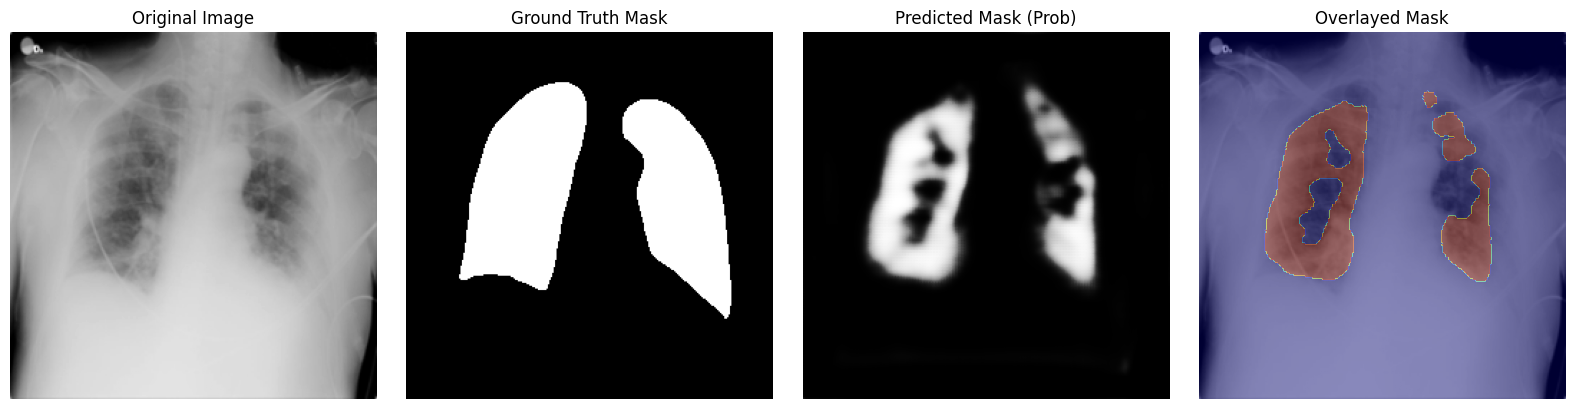

[COVID-1.png] Accuracy: 0.8790 | Dice: 0.6558 | IoU: 0.4879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


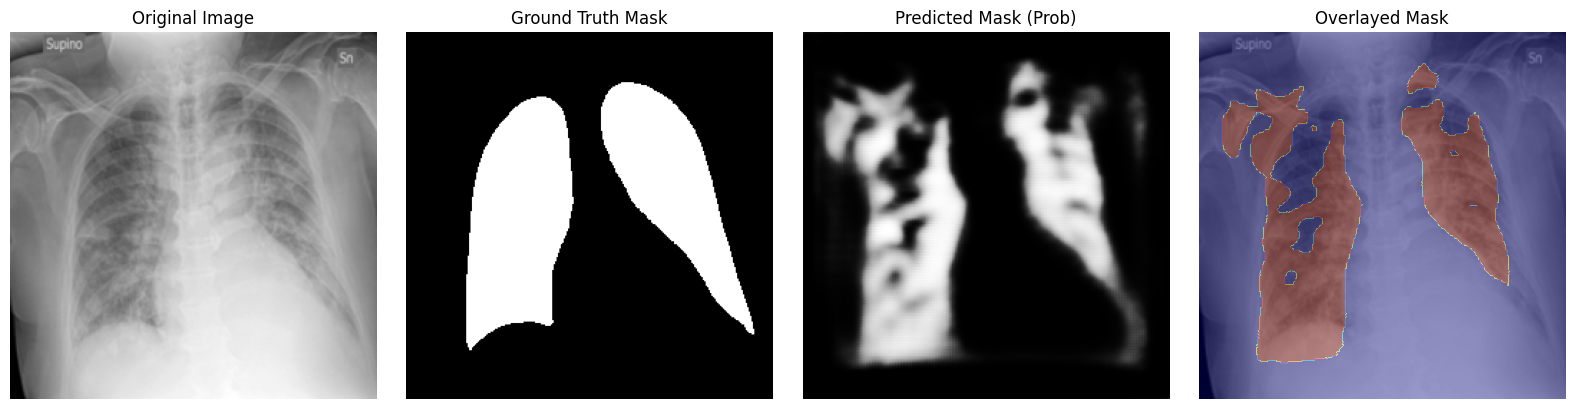

[COVID-10.png] Accuracy: 0.8546 | Dice: 0.7002 | IoU: 0.5387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


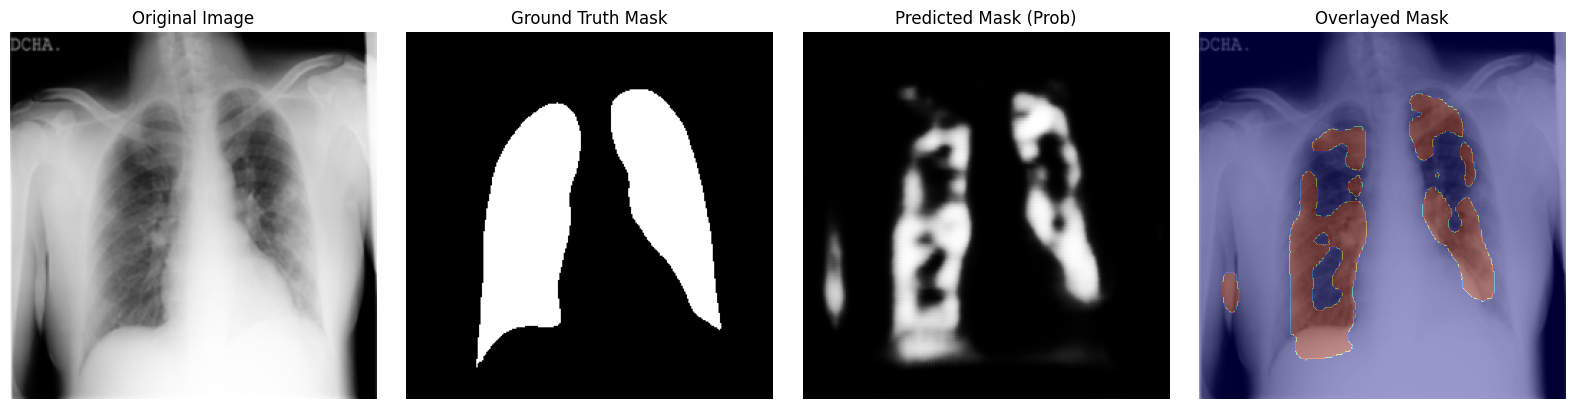

[COVID-100.png] Accuracy: 0.8557 | Dice: 0.5985 | IoU: 0.4270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


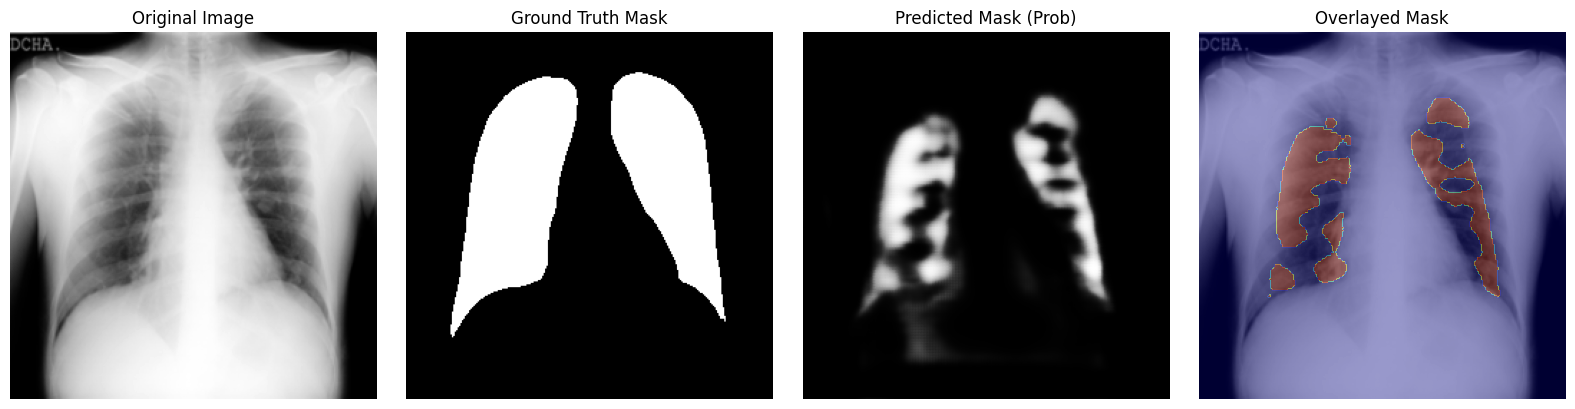

[COVID-1000.png] Accuracy: 0.8351 | Dice: 0.4998 | IoU: 0.3331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


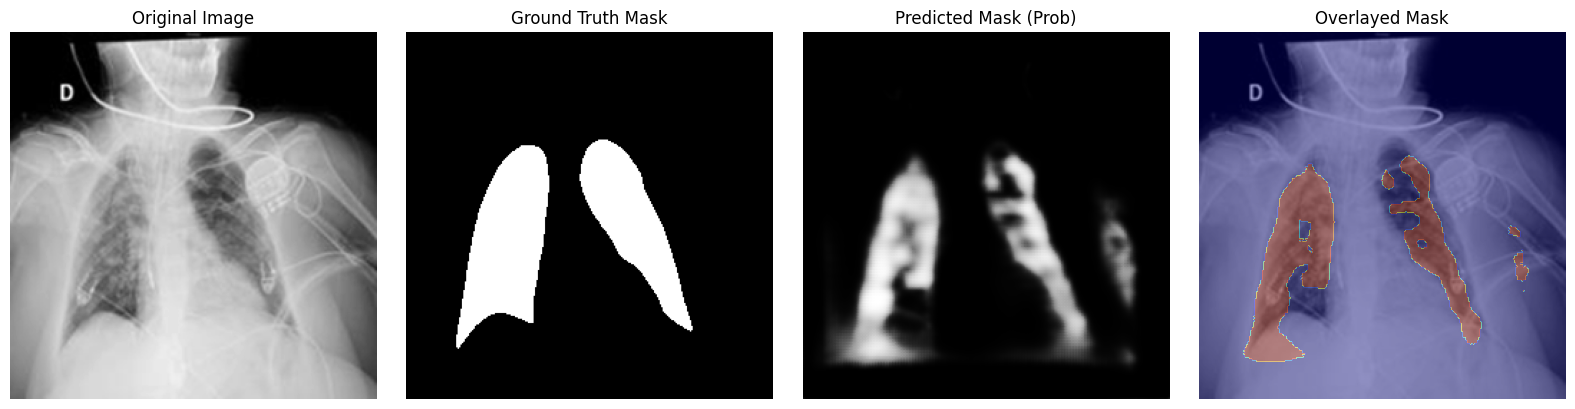

[COVID-1001.png] Accuracy: 0.9221 | Dice: 0.6903 | IoU: 0.5270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


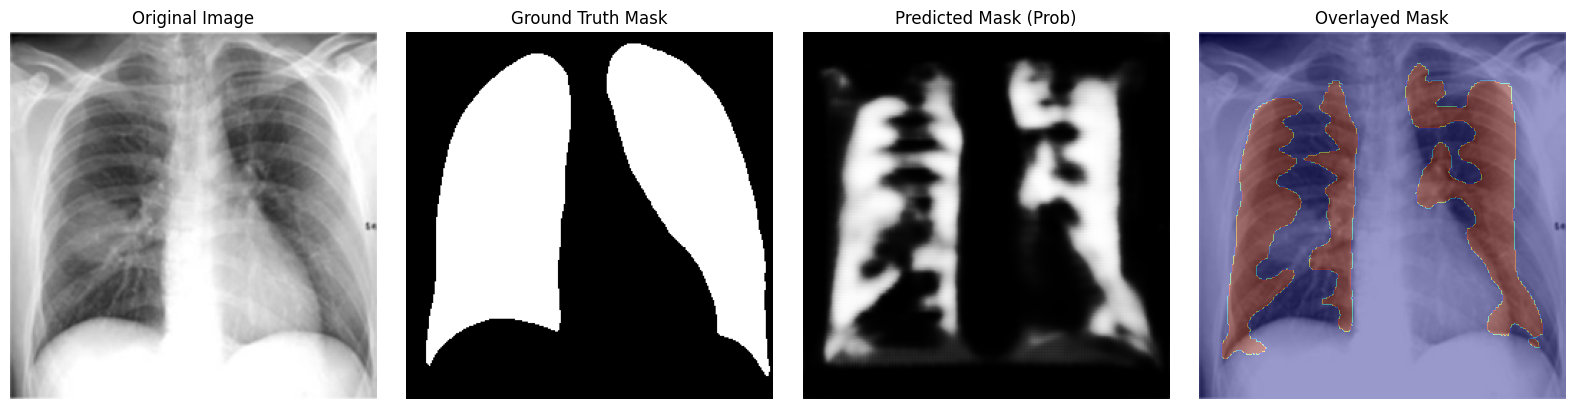

[COVID-1002.png] Accuracy: 0.7786 | Dice: 0.6631 | IoU: 0.4960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


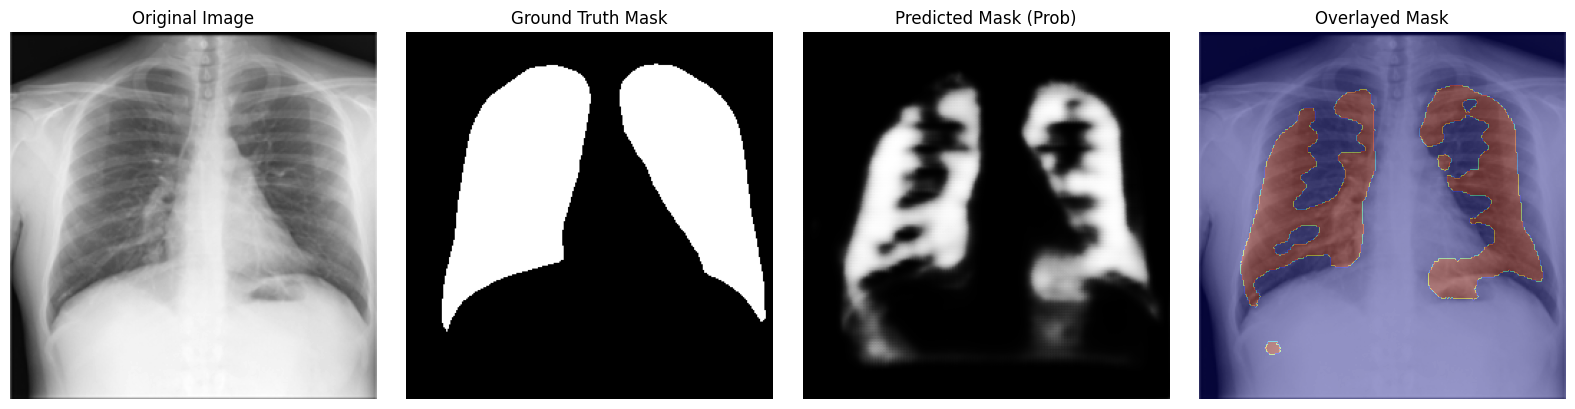

[COVID-1003.png] Accuracy: 0.8224 | Dice: 0.6450 | IoU: 0.4760
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


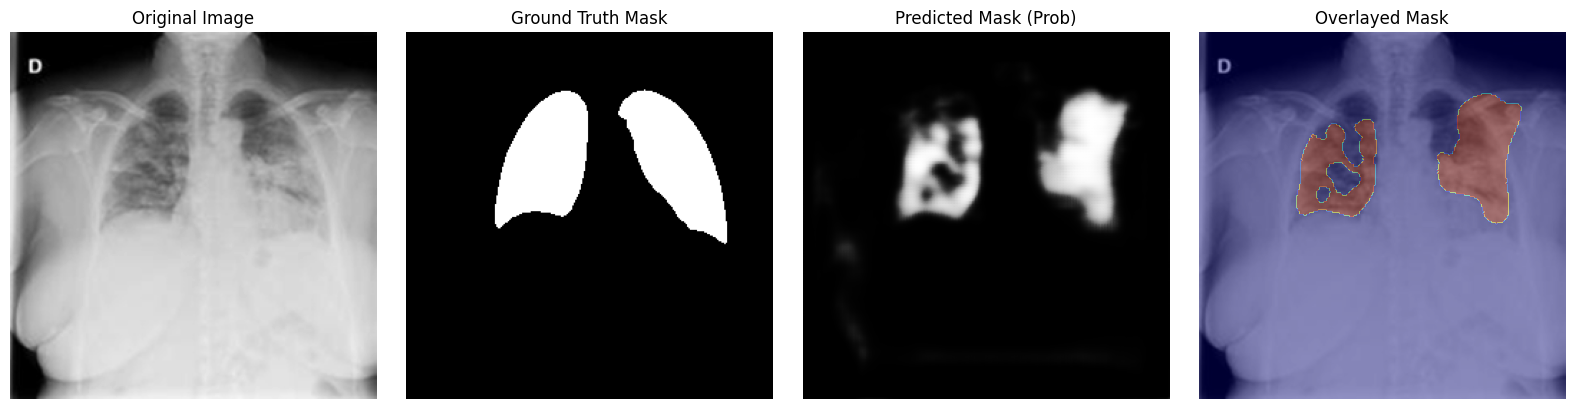

[COVID-1004.png] Accuracy: 0.9282 | Dice: 0.6653 | IoU: 0.4985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


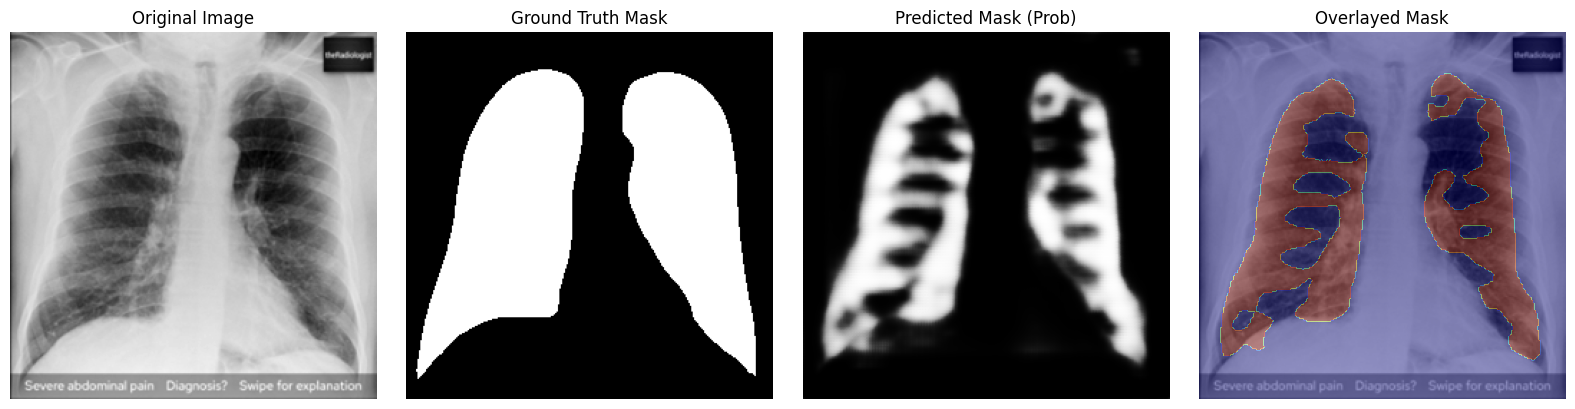

[COVID-1005.png] Accuracy: 0.8177 | Dice: 0.7067 | IoU: 0.5464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


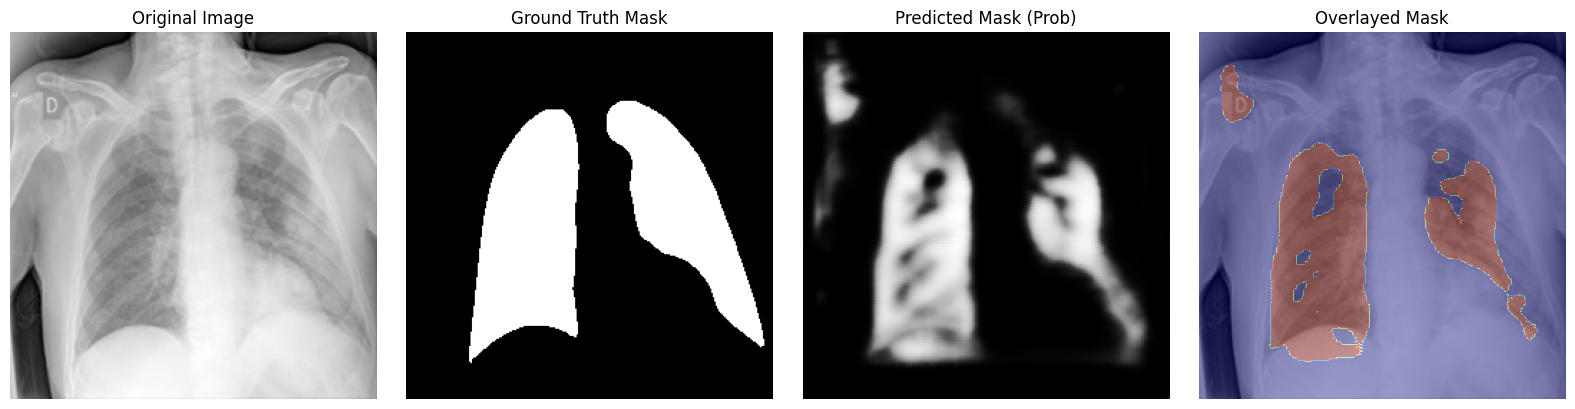

[COVID-1006.png] Accuracy: 0.8687 | Dice: 0.6997 | IoU: 0.5381

Average accuracy (10 images): 0.8562
Average Dice (10 images): 0.6524
Average IoU (10 images): 0.4869


In [51]:
acuracias = []
dices = []
ious = []

# Loop through the first 10 images (or any desired range)
for img_filename in img_filenames[:10]:
    img_path = os.path.join(img_dir, img_filename)
    mask_path = os.path.join(mask_dir, img_filename)
    
    # Load image (as grayscale, resize to 256x256, normalize)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img_input = np.expand_dims(img, axis=(0, -1))

    # Load ground truth mask
    mask_true = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_true = cv2.resize(mask_true, (256, 256))
    mask_true_bin = (mask_true > 127).astype(np.uint8)
    
    # Prediction
    mask_pred = model.predict(img_input)[0, :, :, 0]
    mask_pred_bin = (mask_pred > 0.5).astype(np.uint8)
    
    # Metrics
    accuracy_pixel = np.mean(mask_true_bin == mask_pred_bin)
    acuracias.append(accuracy_pixel)
    
    dice = dice_coef_np(mask_true_bin, mask_pred_bin)
    iou = iou_coef_np(mask_true_bin, mask_pred_bin)
    dices.append(dice)
    ious.append(iou)
    
    # Visualization (optional)
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(mask_true_bin, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('Predicted Mask (Prob)')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask_pred_bin, cmap='jet', alpha=0.4)
    plt.title('Overlayed Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"[{img_filename}] Accuracy: {accuracy_pixel:.4f} | Dice: {dice:.4f} | IoU: {iou:.4f}")

print(f"\nAverage accuracy (10 images): {np.mean(acuracias):.4f}")
print(f"Average Dice (10 images): {np.mean(dices):.4f}")
print(f"Average IoU (10 images): {np.mean(ious):.4f}")